# Комплексный обзор и анализ алгоритма для задачи выбора жениха

### **Общая цель и описание задачи**
Алгоритм решает задачу оптимальной остановки, известную как задача "Секретаря" (или "задача выбора жениха"), в которой целью является максимизация вероятности выбора наилучшего кандидата (жениха) из последовательности. Алгоритм анализирует ранжированные по качеству предложения кандидатов и принимает решение о том, когда остановиться и выбрать кандидата, основываясь на накопленной информации.

### **Используемый подход**
Алгоритм основан на методе обучения с подкреплением (RL) и реализован с помощью модели PPO (Proximal Policy Optimization), одного из популярных подходов в RL. PPO является методом политики, который обучает агента (в данном случае — алгоритм выбора жениха) на основе опыта взаимодействий с окружением (средой), обновляя политику выборов (стратегию принятия решений) таким образом, чтобы улучшить вероятности достижения поставленной цели — выбрать наилучшего кандидата.

#### **Основные особенности PPO:**
- **Постепенное обновление политики:** PPO ограничивает обновления политики с использованием "клиппинга" (clip range), чтобы предотвратить слишком резкие изменения, что делает обучение более стабильным и менее подверженным перегрузкам.
- **Использование батчей и мини-батчей:** PPO использует мини-батчи из опыта для обновления политики, что позволяет лучше усреднить градиенты и улучшить общую устойчивость процесса обучения.
- **Поддержка энтропийного коэффициента (ent_coef):** В алгоритме используется коэффициент энтропии для поддержки исследования (exploration), что помогает агенту рассматривать различные стратегии и избегать преждевременной конвергенции к одной стратегии.

### **Структура алгоритма**
1. **Создание среды (GroomSelectionEnv):** 
   Алгоритм взаимодействует с окружением, которое моделирует процесс выбора жениха. В среде кандидаты представлены как числа, а агент учится оптимально решать, когда остановиться и выбрать лучшего кандидата, основываясь на их ранжировании и индексации.
2. **Обучение модели PPO:**
   - Начальные параметры модели: Для обучения используется нейросеть с политикой `MlpPolicy`, оптимизированной с помощью алгоритма PPO.
   - Обучение происходит итерациями: За каждый интервал обучения (задан параметром `eval_interval`) модель обучается и оценивается, что позволяет следить за прогрессом в выборе лучших кандидатов.
   - Сглаживание результатов: Для уменьшения шумов и улучшения стабильности используется скользящее среднее вероятности выбора лучшего кандидата.
3. **Оценка и улучшение:**
   - Оценка вероятности выбора лучшего кандидата выполняется на каждом шаге. Если вероятность улучшилась, то среда вознаграждает модель, устанавливая награду за улучшение. Это обеспечивает мотивацию модели не только выбирать лучших кандидатов, но и постоянно улучшать свою стратегию.
4. **Логирование и визуализация:**
   - Алгоритм сохраняет логи в файл JSON, что позволяет отслеживать ключевые результаты, такие как количество кандидатов, количество итераций и процент успешных выборов лучших кандидатов.
   - После завершения обучения строится график, показывающий изменение вероятности выбора лучшего кандидата по мере обучения.

### **Теоретическое обоснование**
Задача оптимальной остановки, используемая в этом проекте, является классической математической задачей с реальными приложениями, такими как выбор сотрудников на работу или решения инвестиционных вопросов. Теоретически доказано, что для задачи "Секретаря" существует оптимальная стратегия, которая состоит в том, чтобы пропустить первые \(n/e\) кандидатов (где \(e\) — основание натурального логарифма) и затем выбрать первого кандидата, который превосходит всех предыдущих.

В данном случае, алгоритм PPO изучает похожую стратегию путем взаимодействия с окружением и обучения на основе наград за успешный выбор кандидатов. Это позволяет агенту выявить оптимальные моменты для выбора женихов, не полагаясь на предопределенные правила, а обучаясь адаптироваться к разным числам кандидатов и ситуациям.

### **Заключение**
Представленный алгоритм представляет собой гибкий и адаптивный подход к решению задачи выбора жениха на основе обучения с подкреплением. Он эффективно использует возможности алгоритма PPO для постоянного улучшения стратегии выбора кандидатов через итерации, оценку и обратную связь. Использование методов RL в задаче выбора жениха является удачным примером применения современных методов машинного обучения для решения классических задач оптимальной остановки.


# Входные данные модели:
1. progress: Прогресс в процессе выбора, показывающий долю просмотренных кандидатов (от 0 до 1).

2. is_better_than_previous: Бинарное значение, указывающее, лучше (1.0) или хуже (0.0) текущий кандидат по сравнению с максимальным из всех просмотренных.

# Награды:
Если выбран лучший жених с максимальным рейтингом: 1.0

Если выбран не лучший жених: 0.0

# Штрафы:
Штрафы не предусмотрены

# Импорт необходимых библиотек

In [39]:
import json
import numpy as np
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt

from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Класс для создания среды выбора кандидатов

In [40]:
class GroomSelectionEnv(gym.Env):
    def __init__(self, n_candidates=100):
        super().__init__()  # Инициализация базового класса Gym Env
        self.n_candidates = n_candidates  # Задаем количество женихов (кандидатов)
        self.candidates = []  # Список для хранения значений женихов
        self.current_step = 0  # Текущий шаг в эпизоде
        self.best_candidate_index = -1  # Индекс лучшего жениха (определяется позже)
        self.skipped_grooms_count = 0  # Счетчик пропущенных женихов
        self.viewed_candidates = []  # Список для хранения значений просмотренных женихов

        # Определяем пространство действий (два действия: пропустить или выбрать жениха)
        self.action_space = spaces.Discrete(2)
        
        # Определяем пространство наблюдений (прогресс и лучше или хуже текущий кандидат)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(2,), dtype=np.float32  # Два наблюдения: прогресс и бинарный параметр (лучше или хуже)
        )

    def step(self, action):
        # Если текущий шаг больше или равен количеству кандидатов, эпизод завершается
        if self.current_step >= self.n_candidates - 1:
            terminated = True  # Эпизод завершен
            chosen_groom = True  # Жених выбран
            
            # Оценка, был ли выбран лучший жених на последнем шаге
            if self.current_step - 1 == self.best_candidate_index:
                reward = 1.0  # Полная награда за выбор лучшего жениха
            else:
                reward = 0.0  # Минимальная награда за выбор не лучшего жениха
            return self._get_obs(), reward, terminated, False, {"chosen_groom": chosen_groom}  # Возвращаем наблюдение, награду и статус завершения эпизода

        reward = 0  # Начальная награда
        terminated = False  # Эпизод не завершен
        chosen_groom = False  # Жених пока не выбран

        # Если действие – выбрать жениха
        if action == 1:
            chosen_groom = True  # Жених выбран
            if self.current_step == self.best_candidate_index:
                reward = 1.0  # Полная награда за выбор лучшего жениха
            terminated = True  # Эпизод завершается
        else:
            # Если жених пропущен
            self.viewed_candidates.append(self.candidates[self.current_step])  # Добавляем значение текущего жениха в список просмотренных
            self.skipped_grooms_count += 1  # Увеличиваем счетчик пропусков
            self.current_step += 1  # Переходим к следующему кандидату

        return self._get_obs(), reward, terminated, False, {"chosen_groom": chosen_groom}  # Возвращаем наблюдение, награду и статус завершения

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Сбрасываем базовое состояние среды
        # Генерируем случайные значения для женихов
        self.candidates = np.random.uniform(0, 1, self.n_candidates)
        # Определяем индекс лучшего жениха (максимум в списке кандидатов)
        self.best_candidate_index = np.argmax(self.candidates)
        self.current_step = 0  # Сбрасываем текущий шаг
        self.skipped_grooms_count = 0  # Сбрасываем счетчик пропусков
        self.viewed_candidates = []  # Сбрасываем список просмотренных женихов
        return self._get_obs(), {}  # Возвращаем первое наблюдение

    def _get_obs(self):
        progress = min(1.0, self.current_step / self.n_candidates)  # Прогресс как отношение текущего шага к количеству кандидатов

        # Определяем, лучше или хуже текущий кандидат по сравнению с максимальным из просмотренных
        if self.current_step >= self.n_candidates:
            is_better_than_previous = 0.0  # Если количество кандидатов превышено, устанавливаем 0.0
        elif self.viewed_candidates:
            best_viewed_value = max(self.viewed_candidates)
            is_better_than_previous = 1.0 if self.candidates[self.current_step] > best_viewed_value else 0.0
        else:
            is_better_than_previous = 1.0  # Если нет просмотренных кандидатов, текущий кандидат считается лучшим

        return np.array([progress, is_better_than_previous], dtype=np.float32)  # Возвращаем текущее наблюдение


# Вспомогательная функция для преобразования данных в сериализуемые типы

In [ ]:
def convert_to_serializable(data):
    if isinstance(data, (np.float32, np.float64)):
        return float(data)  # Преобразуем float32 и float64 в обычный float
    elif isinstance(data, (np.int32, np.int64)):
        return int(data)  # Преобразуем int32 и int64 в обычный int
    elif isinstance(data, np.bool_):
        return bool(data)  # Преобразуем np.bool_ в обычный bool
    elif isinstance(data, list):
        return [convert_to_serializable(item) for item in data]  # Рекурсивно обрабатываем список
    elif isinstance(data, dict):
        return {key: convert_to_serializable(value) for key, value in data.items()}  # Рекурсивно обрабатываем словарь
    return data  # Возвращаем неизмененные данные

# Функция для оценки вероятности выбора лучшего жениха

In [ ]:
def evaluate_best_groom_probability(env, model, n_episodes=50, log=False):
    total_best_groom_selections = 0  # Счетчик правильных выборов лучшего жениха
    results = []  # Логи для финальной оценки, если log=True
    
    for episode in range(n_episodes):
        obs, _ = env.reset()  # Сбрасываем среду
        done = False  # Флаг завершения эпизода
        skipped_grooms_count = 0  # Счетчик пропущенных женихов
        episode_log = {"iteration": episode + 1, "steps": []}  # Лог для текущей итерации
        
        while not done:
            action, _states = model.predict(obs, deterministic=True)  # Прогнозируем действие модели
            obs, reward, terminated, truncated, info = env.step(action)  # Выполняем шаг
            done = terminated or truncated  # Проверяем, завершен ли эпизод
            
            # Логируем только если флаг log=True
            if log:
                step_log = {
                    "current_step": env.current_step + 1,  # Текущий шаг (прибавляем 1 для более понятного отображения)
                    "current_groom_value": round(float(obs[0]), 3),  # Текущее значение жениха
                    "comparison_groom_value": round(np.max(env.candidates[:env.current_step + 1]), 3),  # Максимальное значение среди пропущенных женихов
                    "action": "skip" if action == 0 else "select",  # Действие: пропуск или выбор
                    "best_groom_value": round(env.candidates[env.best_candidate_index], 3),  # Значение лучшего жениха
                    "best_groom_index": env.best_candidate_index  # Индекс лучшего жениха
                }
                episode_log["steps"].append(step_log)  # Добавляем лог шага в лог эпизода
                
            if action == 0:  # Если действие – пропуск жениха
                skipped_grooms_count += 1  # Увеличиваем счетчик пропусков
        
        selected_best_groom = bool(env.current_step == env.best_candidate_index)  # Проверяем, был ли выбран лучший жених
        episode_log["selected_best_groom"] = selected_best_groom  # Логируем результат выбора
        episode_log["skipped_grooms_count"] = skipped_grooms_count  # Логируем количество пропущенных женихов
        
        if selected_best_groom:
            total_best_groom_selections += 1  # Увеличиваем счетчик правильных выборов
        
        if log:
            results.append(episode_log)  # Сохраняем лог эпизода
    
    probability = total_best_groom_selections / n_episodes  # Вычисляем вероятность выбора лучшего жениха
    
    if log:
    # Если параметр log установлен в True, создается лог данных для записи в файл
        log_data = {
            "n_candidates": env.n_candidates,  # Количество кандидатов
            "n_iterations": n_episodes,        # Количество итераций
            "best_selection_percentage": float(probability * 100),  # Вероятность выбора лучшего кандидата в процентах
            "details": results  # Детальная информация о результатах
        }
        log_filename = "groom_selection_log.json"  # Имя файла для сохранения лога
        with open(log_filename, "w") as f:
            # Открываем файл на запись и сохраняем данные в формате JSON
            json.dump(convert_to_serializable(log_data), f, indent=4)
        print(f"Лог сохранен в файл: {log_filename}")  # Сообщение о том, что лог сохранен
        
    return probability  # Возвращаем вероятность выбора лучшего жениха

# Функция для обучения модели

In [ ]:
def train_model(env, model, total_timesteps=200000, eval_interval=5000, eval_episodes=100):
    train_model.last_probability = 0  # Инициализируем переменную для последней вероятности
    train_model.best_probability = 0  # Инициализируем переменную для лучшей вероятности
    probabilities = []  # Список для хранения вероятностей на каждом шаге
    
    # Скользящее среднее для сглаживания вероятности
    window_size = 3  # Размер окна для скользящего среднего
    last_probabilities = [0] * window_size  # Инициализируем массив для хранения последних вероятностей
    print("Обучение алгоритма:")  # Сообщение о начале обучения
    
    for step in range(0, total_timesteps, eval_interval):
        # Основной цикл обучения, выполняем обучение с интервалом оценки
        model.learn(total_timesteps=eval_interval, reset_num_timesteps=False, progress_bar=False)
        
        # Оцениваем вероятность выбора лучшего жениха без логирования во время обучения
        probability = evaluate_best_groom_probability(env, model, n_episodes=eval_episodes, log=False)
        
        # Обновляем скользящее среднее
        last_probabilities = last_probabilities[1:] + [probability]  # Добавляем текущую вероятность
        smoothed_probability = sum(last_probabilities) / window_size  # Вычисляем скользящее среднее
        
        # Проверяем, улучшилась ли вероятность
        if smoothed_probability > train_model.best_probability:
            # Если вероятность улучшилась, обновляем лучшую вероятность
            train_model.best_probability = smoothed_probability  # Обновляем лучшую вероятность
        
        # Выводим информацию о шаге обучения и текущей вероятности
        print(f"Шаг {step}: Вероятность выбора лучшего жениха: {probability:.2f}")
        
        train_model.last_probability = probability  # Обновляем последнюю вероятность
        probabilities.append(probability)  # Добавляем вероятность в список
    
    return probabilities  # Возвращаем список вероятностей


# Создание модели

In [ ]:
env = GroomSelectionEnv(n_candidates=100)  # Создаем окружение с 100 кандидатами
vec_env = DummyVecEnv([lambda: env])  # Оборачиваем окружение для работы с векторизированной средой
model = PPO(
    "MlpPolicy",  # Используем многослойную политику
    vec_env,  # Передаем окружение
    learning_rate=0.0001,  # Снижаем скорость обучения для более стабильного обучения
    n_steps=2048,  # Увеличиваем количество шагов в одном батче
    batch_size=64,  # Размер батча
    ent_coef=0.003,  # Коэффициент энтропии для уменьшения случайности в обучении
    gamma=0.99,  # Коэффициент дисконтирования для будущих наград
    verbose=0,  # Выключаем вывод подробной информации
    clip_range=0.1,  # Ограничиваем clip_range для консервативных обновлений
)

# Обучение модели

In [ ]:
probabilities = train_model(env, model, total_timesteps=200000)

Обучение алгоритма:
Шаг 0: Вероятность выбора лучшего жениха: 0.01
Шаг 5000: Вероятность выбора лучшего жениха: 0.02
Шаг 10000: Вероятность выбора лучшего жениха: 0.02
Шаг 15000: Вероятность выбора лучшего жениха: 0.01
Шаг 20000: Вероятность выбора лучшего жениха: 0.00
Шаг 25000: Вероятность выбора лучшего жениха: 0.02
Шаг 30000: Вероятность выбора лучшего жениха: 0.02
Шаг 35000: Вероятность выбора лучшего жениха: 0.00
Шаг 40000: Вероятность выбора лучшего жениха: 0.00
Шаг 45000: Вероятность выбора лучшего жениха: 0.01
Шаг 50000: Вероятность выбора лучшего жениха: 0.01
Шаг 55000: Вероятность выбора лучшего жениха: 0.03
Шаг 60000: Вероятность выбора лучшего жениха: 0.19
Шаг 65000: Вероятность выбора лучшего жениха: 0.36
Шаг 70000: Вероятность выбора лучшего жениха: 0.38
Шаг 75000: Вероятность выбора лучшего жениха: 0.36
Шаг 80000: Вероятность выбора лучшего жениха: 0.47
Шаг 85000: Вероятность выбора лучшего жениха: 0.31
Шаг 90000: Вероятность выбора лучшего жениха: 0.31
Шаг 95000: Вероя

# Построение графика изменения вероятности выбора лучшего жениха


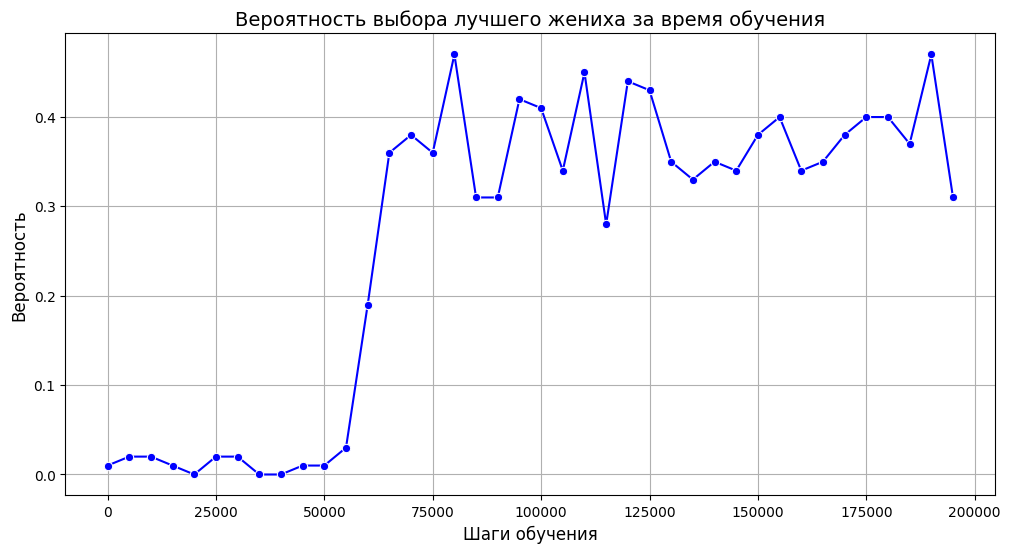

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(0, len(probabilities) * 5000, 5000), y=probabilities, marker='o', color='b')
plt.title('Вероятность выбора лучшего жениха за время обучения', fontsize=14)
plt.xlabel('Шаги обучения', fontsize=12)
plt.ylabel('Вероятность', fontsize=12)
plt.grid(True)
plt.show()

# Финальная оценка вероятности


In [ ]:
final_probability = evaluate_best_groom_probability(env, model, n_episodes=100, log=True)
print(f"\nФинальная вероятность выбора лучшего жениха: {final_probability:.2f}, т.е. {final_probability * 100}%")

Лог сохранен в файл: groom_selection_log.json

Финальная вероятность выбора лучшего жениха: 0.37, т.е. 37.0%


# Создание новой среды для тестирования модели с другим распределением рейтинга кандидатов

In [48]:
class GroomSelectionEnv(gym.Env):
    def __init__(self, n_candidates=100):
        super().__init__()  # Инициализация базового класса Gym Env
        self.n_candidates = n_candidates  # Задаем количество женихов (кандидатов)
        self.candidates = []  # Список для хранения значений женихов
        self.current_step = 0  # Текущий шаг в эпизоде
        self.best_candidate_index = -1  # Индекс лучшего жениха (определяется позже)
        self.skipped_grooms_count = 0  # Счетчик пропущенных женихов
        self.viewed_candidates = []  # Список для хранения значений просмотренных женихов

        # Определяем пространство действий (два действия: пропустить или выбрать жениха)
        self.action_space = spaces.Discrete(2)
        
        # Определяем пространство наблюдений (прогресс и лучше или хуже текущий кандидат)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(2,), dtype=np.float32  # Два наблюдения: прогресс и бинарный параметр (лучше или хуже)
        )

    def step(self, action):
        # Если текущий шаг больше или равен количеству кандидатов, эпизод завершается
        if self.current_step >= self.n_candidates - 1:
            terminated = True  # Эпизод завершен
            chosen_groom = True  # Жених выбран
            
            # Оценка, был ли выбран лучший жених на последнем шаге
            if self.current_step - 1 == self.best_candidate_index:
                reward = 1.0  # Полная награда за выбор лучшего жениха
            else:
                reward = 0.0  # Минимальная награда за выбор не лучшего жениха
            return self._get_obs(), reward, terminated, False, {"chosen_groom": chosen_groom}  # Возвращаем наблюдение, награду и статус завершения эпизода

        reward = 0  # Начальная награда
        terminated = False  # Эпизод не завершен
        chosen_groom = False  # Жених пока не выбран

        # Если действие – выбрать жениха
        if action == 1:
            chosen_groom = True  # Жених выбран
            if self.current_step == self.best_candidate_index:
                reward = 1.0  # Полная награда за выбор лучшего жениха
            terminated = True  # Эпизод завершается
        else:
            # Если жених пропущен
            self.viewed_candidates.append(self.candidates[self.current_step])  # Добавляем значение текущего жениха в список просмотренных
            self.skipped_grooms_count += 1  # Увеличиваем счетчик пропусков
            self.current_step += 1  # Переходим к следующему кандидату

        return self._get_obs(), reward, terminated, False, {"chosen_groom": chosen_groom}  # Возвращаем наблюдение, награду и статус завершения

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Сбрасываем базовое состояние среды
        # Генерируем случайные значения для женихов
        self.candidates = np.random.uniform(0, 0,1, self.n_candidates)
        # Определяем индекс лучшего жениха (максимум в списке кандидатов)
        self.best_candidate_index = np.argmax(self.candidates)
        self.current_step = 0  # Сбрасываем текущий шаг
        self.skipped_grooms_count = 0  # Сбрасываем счетчик пропусков
        self.viewed_candidates = []  # Сбрасываем список просмотренных женихов
        return self._get_obs(), {}  # Возвращаем первое наблюдение

    def _get_obs(self):
        progress = min(1.0, self.current_step / self.n_candidates)  # Прогресс как отношение текущего шага к количеству кандидатов

        # Определяем, лучше или хуже текущий кандидат по сравнению с максимальным из просмотренных
        if self.current_step >= self.n_candidates:
            is_better_than_previous = 0.0  # Если количество кандидатов превышено, устанавливаем 0.0
        elif self.viewed_candidates:
            best_viewed_value = max(self.viewed_candidates)
            is_better_than_previous = 1.0 if self.candidates[self.current_step] > best_viewed_value else 0.0
        else:
            is_better_than_previous = 1.0  # Если нет просмотренных кандидатов, текущий кандидат считается лучшим

        return np.array([progress, is_better_than_previous], dtype=np.float32)  # Возвращаем текущее наблюдение

# Тест

In [ ]:
final_probability = evaluate_best_groom_probability(env, model, n_episodes=100, log=True)
print(f"\nФинальная вероятность выбора лучшего жениха: {final_probability:.2f}, т.е. {final_probability * 100}%")

Лог сохранен в файл: groom_selection_log.json

Финальная вероятность выбора лучшего жениха: 0.37, т.е. 37.0%
